In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt

In [2]:
df_train = pd.read_csv("data/bacteria_train.csv")
x_train = df_train["Spreading_factor"].values.reshape(-1,1)
y_train = df_train["Perc_population"].values

Perform 100 bootstraps of polynomial regression and visualize estimated coefficients.

In [3]:
bootstrap = []
numboot = 100

include_bias = False
fit_intercept = True
best_deg = 3

np.random.seed(109)
for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    x_poly_train = PolynomialFeatures(
        best_deg, include_bias=include_bias
    ).fit_transform(df_boot["Spreading_factor"].values.reshape(-1, 1))
    y_train_boot = df_boot.Perc_population
    linreg_boot = LinearRegression(fit_intercept=fit_intercept)
    linreg_boot.fit(x_poly_train, y_train_boot)
    if fit_intercept==True:
        bootstrap.append([linreg_boot.intercept_, *linreg_boot.coef_])
    else:
        bootstrap.append(linreg_boot.coef_)

bootstrap = np.array(bootstrap)

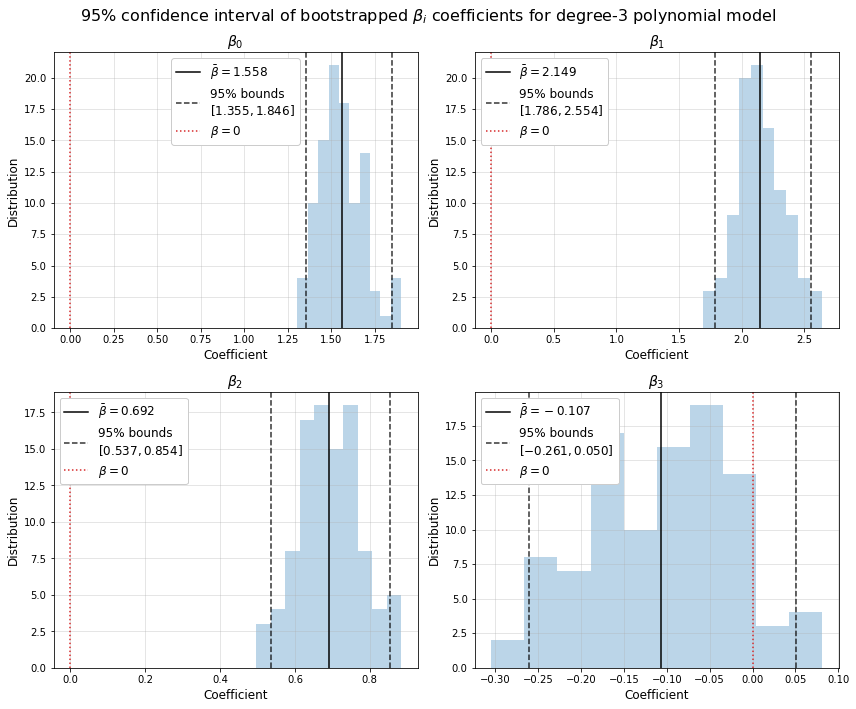


The coefficient values of the degree-3 polynomial regression model fit in Question 2.1 (without bootstrapping) were:



In [4]:
fig, ax = plt.subplots(2,2, sharex=False, figsize = (12,10))

ax = ax.ravel()

for i in range(4):
    betavals = bootstrap[:,i]
    betavals.sort()

    x1 = np.percentile(betavals,2.5)
    x2 = np.percentile(betavals,97.5)
    xbar = np.mean(betavals)

    ax[i].hist(bootstrap[:,i], alpha=0.3)

    ax[i].axvline(
        xbar,
        color="k",
        linestyle="-",
        alpha=1,
        label="$\\bar{{\\beta}} = {:.3f}$".format(xbar),
    )
    ax[i].axvline(
        x1,
        color="k",
        linestyle="--",
        alpha=0.8,
        label="95% bounds\n$[{:.3f}, {:.3f}]$".format(x1, x2),
    )
    ax[i].axvline(x2, color="k", linestyle="--", alpha=0.8)
    ax[i].axvline(
        0,
        color="tab:red",
        linestyle=":",
        alpha=1,
        label="$\\beta=0$",
    )

    ax[i].set_ylabel("Distribution",fontsize=12)
    ax[i].set_xlabel("Coefficient",fontsize=12)
    ax[i].grid(":", alpha=0.4)
    ax[i].set_title(f"$\\beta_{i}$", fontsize=14)
    ax[i].legend(fontsize=12, framealpha=1)
    
#plt.xticks(fontsize=20)
fig.suptitle(
    "$95\%$ confidence interval of bootstrapped $\\beta_i$ "
    "coefficients for degree-{} polynomial model".format(best_deg),
    fontsize=16,
)
plt.tight_layout()
plt.show()

print(
    f"\nThe coefficient values of the degree-{best_deg} "
    "polynomial regression model fit in Question "
    "2.1 (without bootstrapping) were:\n"
)


Hyperparamter tuning with cross validation, and visualize tunning results.

In [5]:
max_degree = 30
degree = max_degree

include_bias = False
fit_intercept = True

train_score = []
validation_score = []
validation_std = []

for d in range(1,degree+1):
    x_poly_train = PolynomialFeatures(
        d, include_bias=include_bias
    ).fit_transform(x_train)
    lin_reg = LinearRegression(fit_intercept=fit_intercept)
    mse_score = cross_validate(
        lin_reg,
        x_poly_train,
        y_train,
        cv=10,
        scoring="neg_mean_squared_error",
        return_train_score=True,
    )
    train_score.append(np.mean(-mse_score["train_score"]))
    validation_score.append(np.mean(-mse_score["test_score"]))
    validation_std.append(np.std(mse_score["test_score"]))

In [6]:
def mse_plot(
    var_list,train_score,val_score,val_std=None,
    title=None,x_label=None,loc="best",log_mse=False,log_xscale=False):

    fig, ax = plt.subplots(figsize=(15, 8))
    
    ax.plot(var_list,train_score,"o--",label="Training",linewidth=2,alpha=0.4)
    ax.plot(var_list,val_score,"^-",label="Validation",markeredgecolor="k",linewidth=2,alpha=0.7)

    if val_std is not None:
        ax.fill_between(
            var_list, 
            np.clip(np.array(val_score)-val_std, a_min=0, a_max=None),
            np.array(val_score)+val_std,
            color="tab:orange",
            alpha=0.2,
            label = "Validation +/-1 standard deviation")

    if log_xscale:
        ax.set_xscale("log")
    
    if log_mse:
        ax.set_yscale("log")
        ax.set_ylabel("$MSE$ (log scaled)", fontsize=12)
    else:
        ax.set_ylabel("$MSE$", fontsize=12)

        
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_title(title, fontsize= 14)
    ax.legend(loc=loc, fontsize =12)
    ax.set_xticks(var_list)
    plt.grid(":", alpha=0.4)
    plt.tight_layout()
    plt.show()

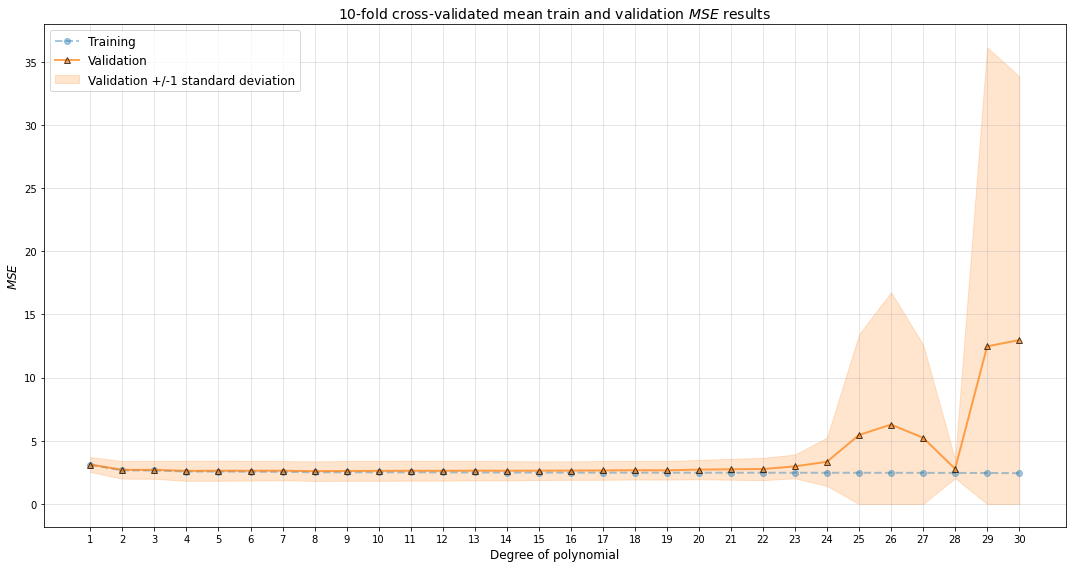

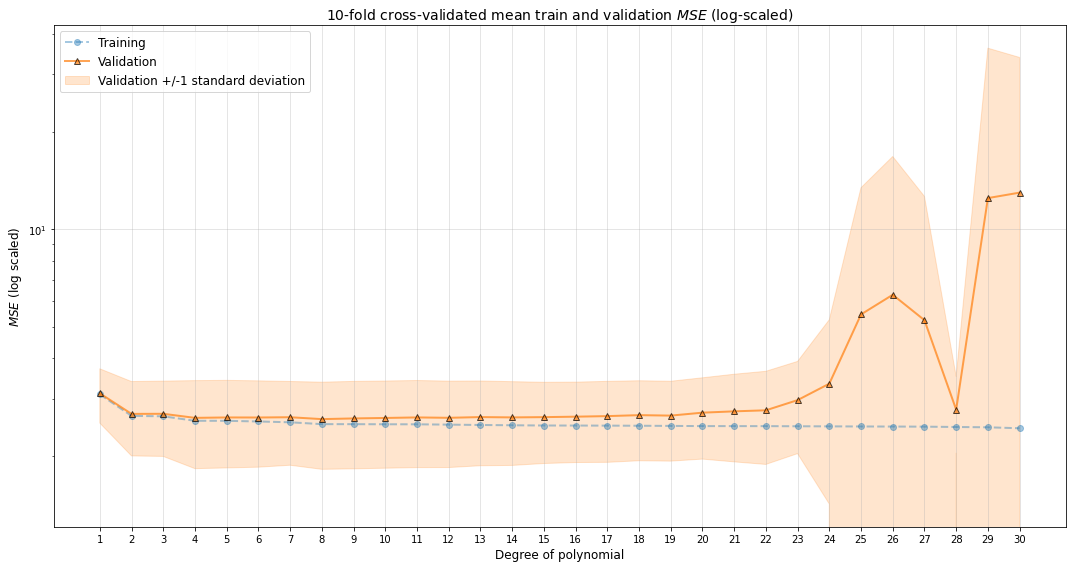


The best model has a degree of 8 with a training MSE of 2.5081 and a validation MSE of 2.5991


In [7]:
x_label = "Degree of polynomial"
title = ("10-fold cross-validated mean train and validation $MSE$ results")

mse_plot(
    var_list=list(range(1, max_degree+1)),
    train_score=train_score,
    val_score=validation_score,
    val_std=validation_std,
    title=title,
    x_label=x_label,
    loc=2,
    log_mse=False,
)

x_label = "Degree of polynomial"
title = ("10-fold cross-validated mean train and validation $MSE$ (log-scaled)")

mse_plot(
    var_list=list(range(1, max_degree+1)),
    train_score=train_score,
    val_score=validation_score,
    val_std=validation_std,
    title=title,
    x_label=x_label,
    loc=2,
    log_mse=True,
)

best_deg = validation_score.index(min(validation_score))+1

print(
    f"\nThe best model has a degree of {best_deg} "
    f"with a training MSE of {train_score[best_deg-1]:.4f}"
    f" and a validation MSE of {min(validation_score):.4f}"
)

Perform 100 bootstraps of lasso regression and visualize the number of being identified as important (> 0.1) for each feature

In [8]:
%%capture --no-stdout --no-display
numboot = 100
max_iter = 100000
significant_degrees = {}
best_alpha = 0.01

for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    x_train_boot = df_boot[["Spreading_factor"]]
    x_poly_train = PolynomialFeatures(
        max_degree, include_bias=include_bias
    ).fit_transform(x_train_boot)
    y_train_boot = df_boot.Perc_population

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=max_iter,
        alpha=best_alpha,
    )
    lasso.fit(x_poly_train, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

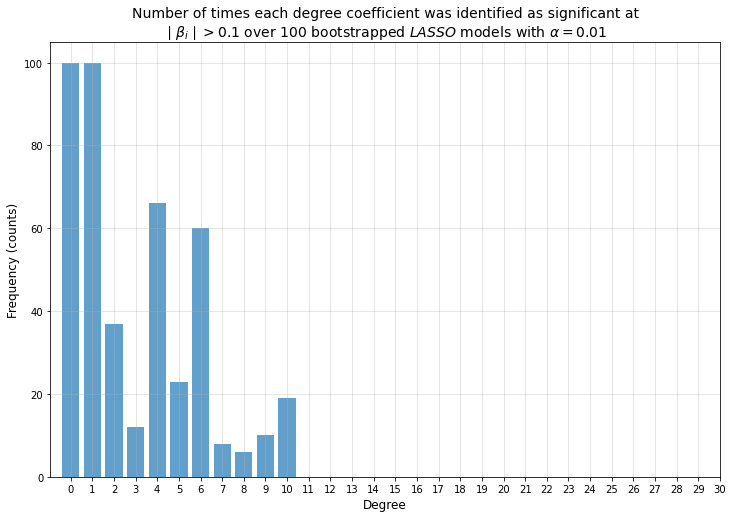

In [9]:
fig, ax = plt.subplots(figsize=(12,8))
lists = sorted(significant_degrees.items())
x, y = zip(*lists)

ax.bar(x, y, alpha=0.7)
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Frequency (counts)", fontsize=12)
ax.set_xticks(range(max_degree+1))
ax.set_title(
    "Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)
plt.show()
